# Imports

In [1]:
import inflection
import numpy as np
import  pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, balanced_accuracy_score, f1_score, make_scorer
from boruta import BorutaPy
from scipy import stats


In [2]:
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 16

C:\Users\Bhaskar Banerjee\AppData\Local\Temp\ipykernel_12600\1501632487.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


# Load dataset

In [3]:
df1=pd.read_csv('Fraud.csv')
df1.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Convert to snakecase

In [4]:
col_old=df1.columns.tolist()
snakecase=lambda x: inflection.underscore(x)
col_new=list(map(snakecase,col_old))
df1.columns=col_new
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

In [5]:
df1.shape

(6362620, 11)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   type              object 
 2   amount            float64
 3   name_orig         object 
 4   oldbalance_org    float64
 5   newbalance_orig   float64
 6   name_dest         object 
 7   oldbalance_dest   float64
 8   newbalance_dest   float64
 9   is_fraud          int64  
 10  is_flagged_fraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Check for NA

In [7]:
df1.isna().mean()

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

# Change DataType

In [8]:
df1['is_fraud']=df1['is_fraud'].map({1:'Yes',0:'No'})
df1['is_flagged_fraud']=df1['is_flagged_fraud'].map({1:'Yes',0:'No'})
df1.head(5)

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,No,No
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,No,No
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,Yes,No
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,Yes,No
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,No,No


# Numerical Attributes

In [9]:
numbered_atr=df1.select_dtypes(exclude='object')
desc_num_atr=numbered_atr.describe().T
desc_num_atr['range']=(numbered_atr.max()-numbered_atr.min()).tolist()
desc_num_atr['variation_coeficient']=(numbered_atr.std()/numbered_atr.mean()).tolist()
desc_num_atr['skew']=numbered_atr.skew().tolist()
desc_num_atr['kurtosis']=numbered_atr.kurtosis().tolist()
desc_num_atr

,count,mean,std,min,25%,50%,75%,max,range,variation_coeficient,skew,kurtosis
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02,7.420000e+02,0.584772,0.375177,0.329071
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07,9.244552e+07,3.357344,30.993949,1797.956705
oldbalance_org,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07,5.958504e+07,3.463606,5.249136,32.964879
newbalance_orig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07,4.958504e+07,3.419485,5.176884,32.066985
oldbalance_dest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08,3.560159e+08,3.088194,19.921758,948.674125
newbalance_dest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08,3.561793e+08,2.999298,19.352302,862.156508


# Categorical Attributes

In [10]:
categorical_atr=df1.select_dtypes(include='object')
categorical_atr.describe()

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
count,6362620,6362620,6362620,6362620,6362620
unique,5,6353307,2722362,2,2
top,CASH_OUT,C1902386530,C1286084959,No,No
freq,2237500,3,113,6354407,6362604


In [11]:
df2=df1.copy()

# Feature Engineering

In [12]:
df2['step_days']=df2['step'].apply(lambda x: x/24)
df2['step_weeks']=df2['step_days'].apply(lambda x: x/7)
df2['diff_sender_amount']=df2['newbalance_orig']-df2['oldbalance_org']
df2['diff_reciever_amount']=df2['newbalance_dest']-df2['oldbalance_dest']
df2['name_orig']=df2['name_orig'].apply(lambda x: x[0])
df2['name_dest']=df2['name_dest'].apply(lambda x: x[0])
df2.head(5)

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_sender_amount,diff_reciever_amount
0,1,PAYMENT,9839.64,C,170136.0,160296.36,M,0.0,0.0,No,No,0.041667,0.005952,-9839.64,0.0
1,1,PAYMENT,1864.28,C,21249.0,19384.72,M,0.0,0.0,No,No,0.041667,0.005952,-1864.28,0.0
2,1,TRANSFER,181.00,C,181.0,0.00,C,0.0,0.0,Yes,No,0.041667,0.005952,-181.00,0.0
3,1,CASH_OUT,181.00,C,181.0,0.00,C,21182.0,0.0,Yes,No,0.041667,0.005952,-181.00,-21182.0
4,1,PAYMENT,11668.14,C,41554.0,29885.86,M,0.0,0.0,No,No,0.041667,0.005952,-11668.14,0.0


In [13]:
df3=df2.copy()

# Response Variable

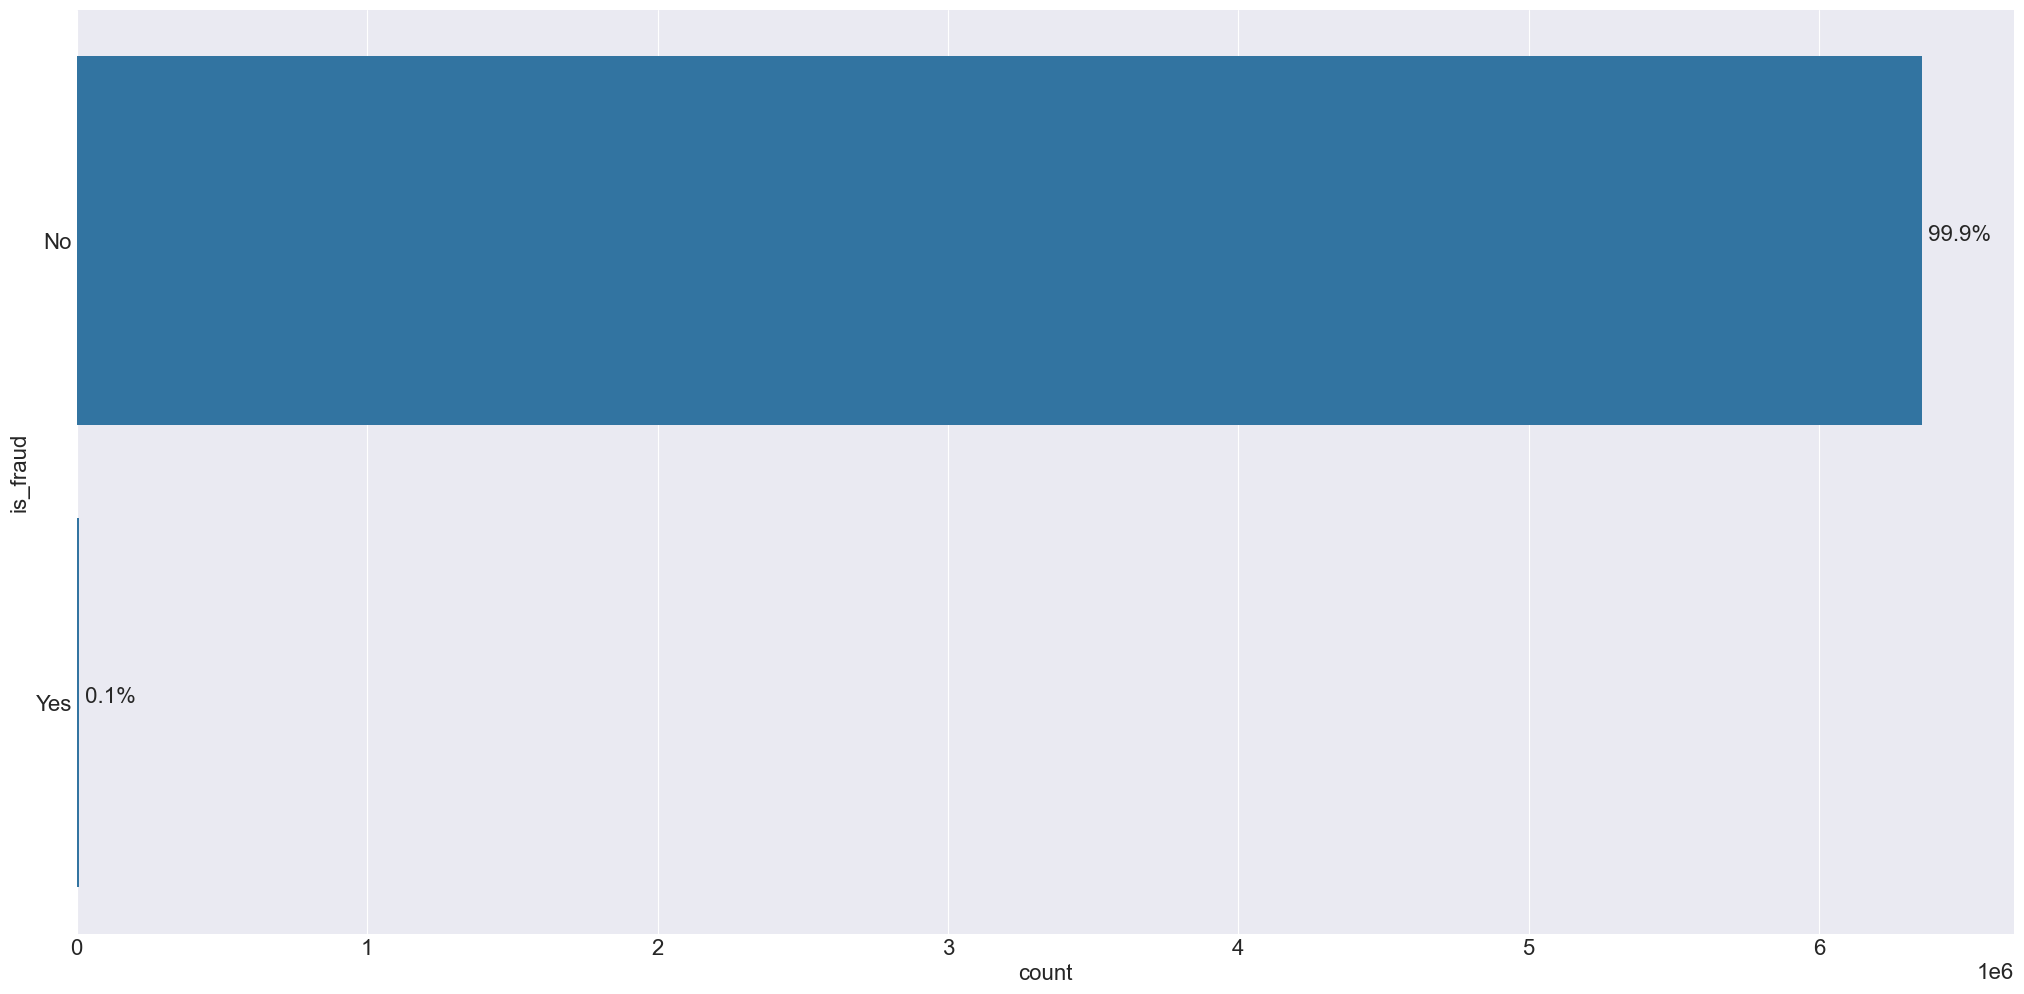

In [14]:
ax=sns.countplot(y='is_fraud',data=df3)
total=df3['is_fraud'].size
for i in ax.patches:
    percent=' {:.1f}%'.format((i.get_width()/total)*100)
    x=i.get_x()+i.get_width()+0.02
    y=i.get_y()+i.get_height()/2
    ax.annotate(percent,(x,y))

# Numerical Variables

__Note__: There is some problem in my ide therefore below graphs are  not showing up. Please use the Jupyter Notebook provided to view these plots. 

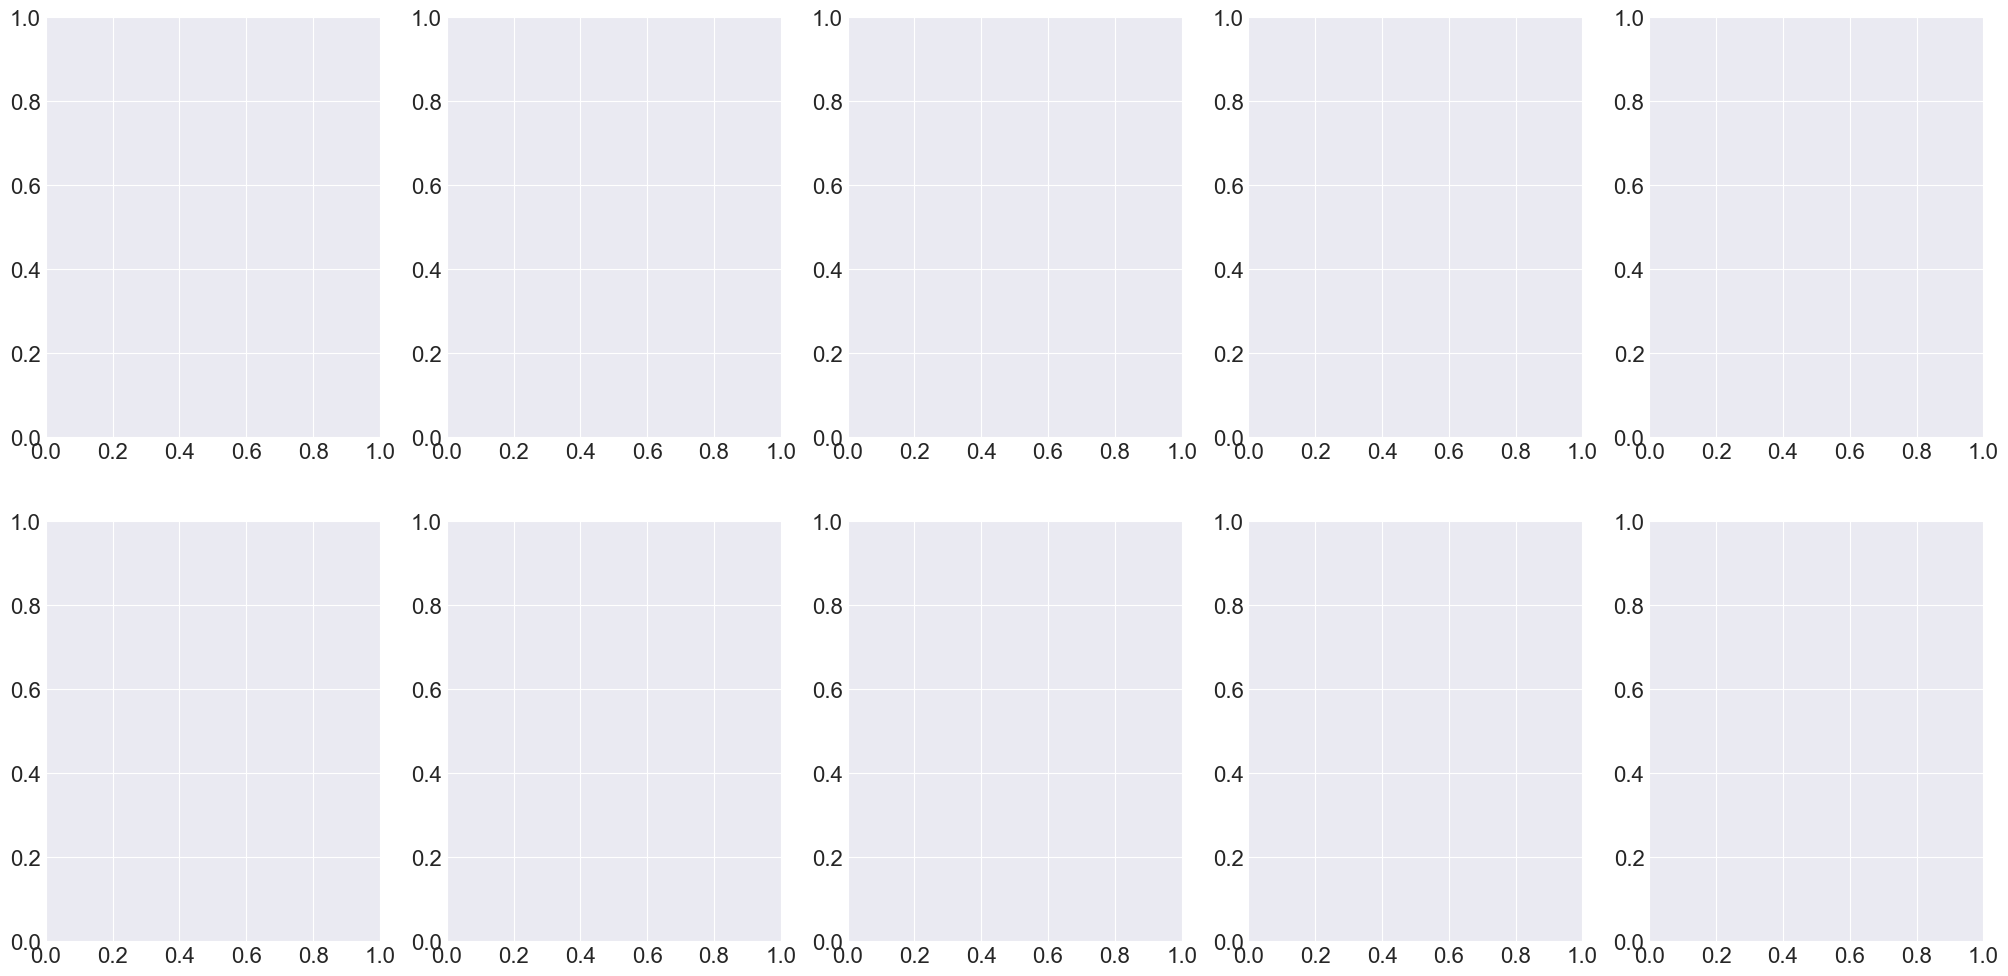

In [15]:
num_attributes = df3.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 5, j)
    # sns.histplot(num_attributes[column], kde=True,
    # stat="density", kde_kws=dict(cut=3),
    # alpha=.4, edgecolor=(1, 1, 1, .4),);
    
    j += 1

# Categorical Variables

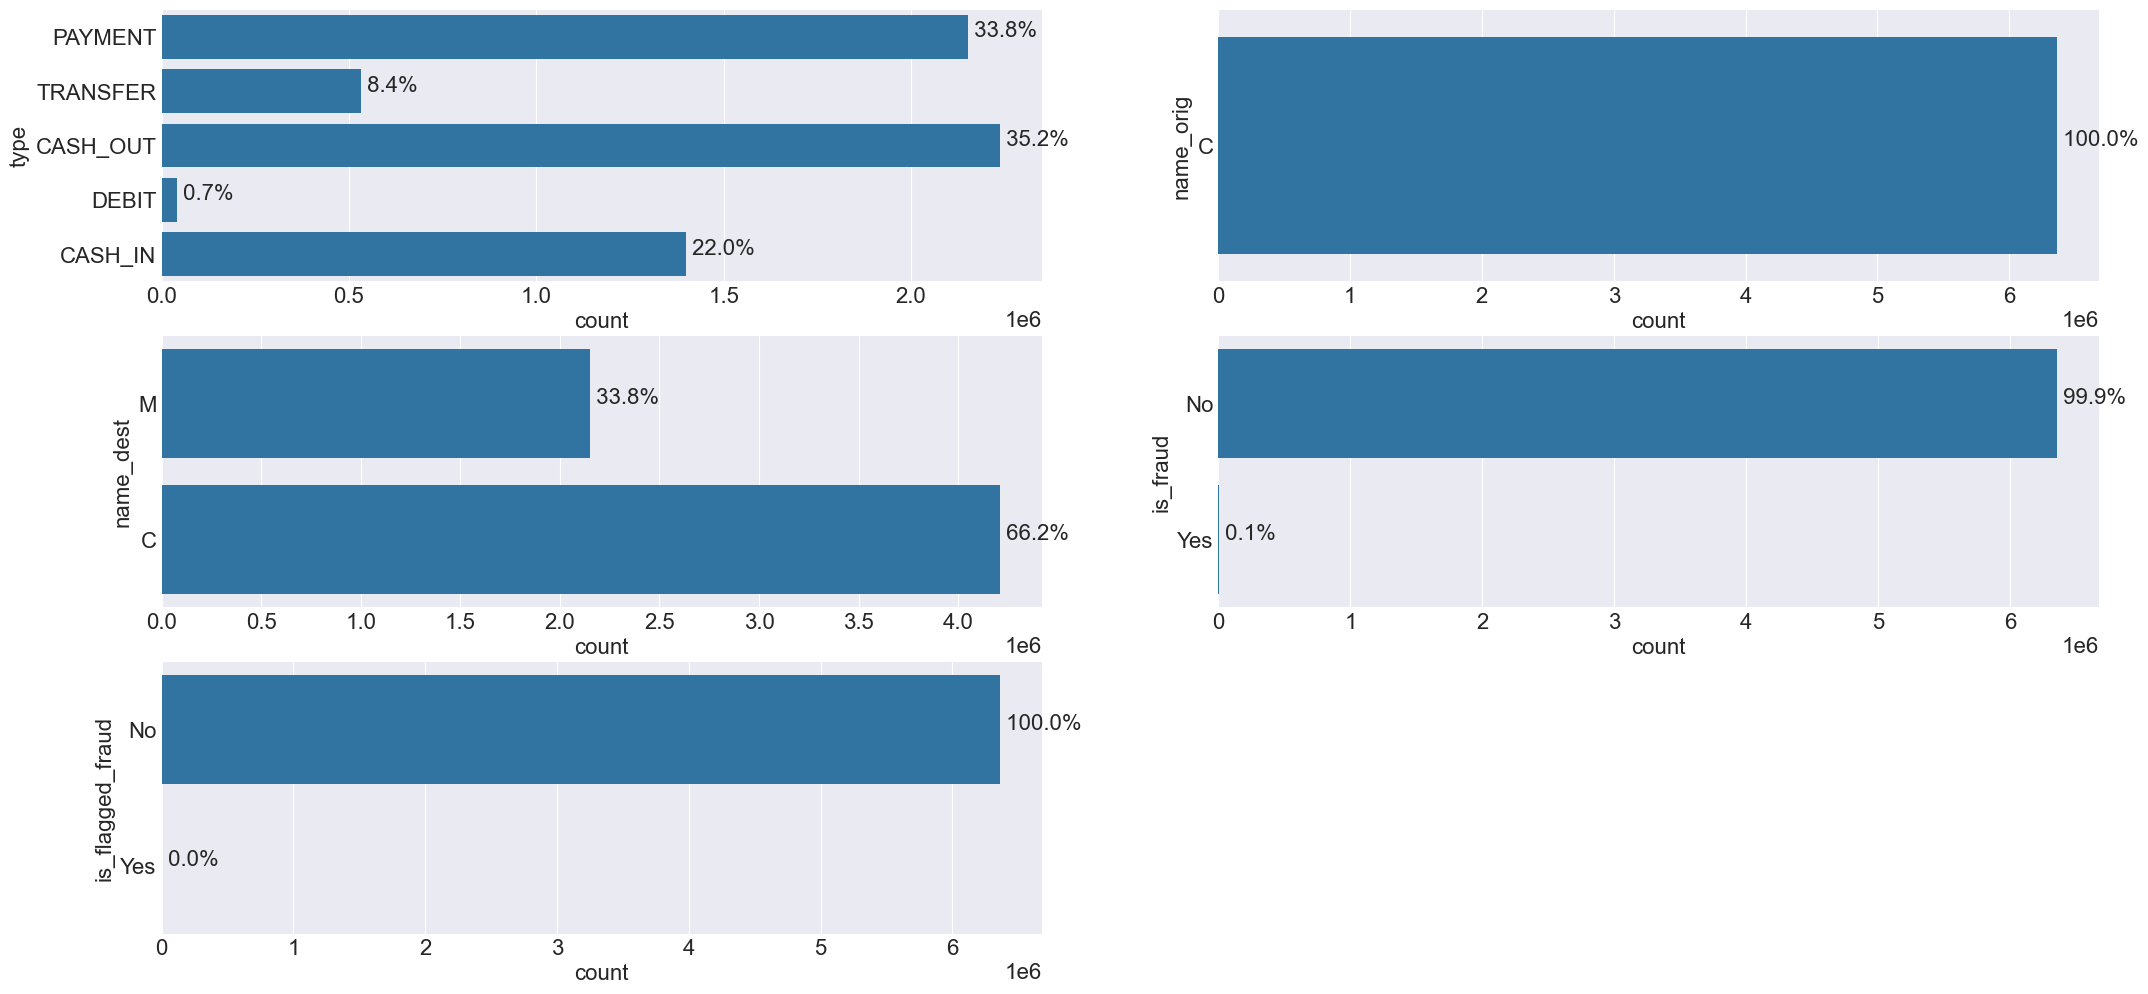

In [16]:
cat_attributes = df3.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

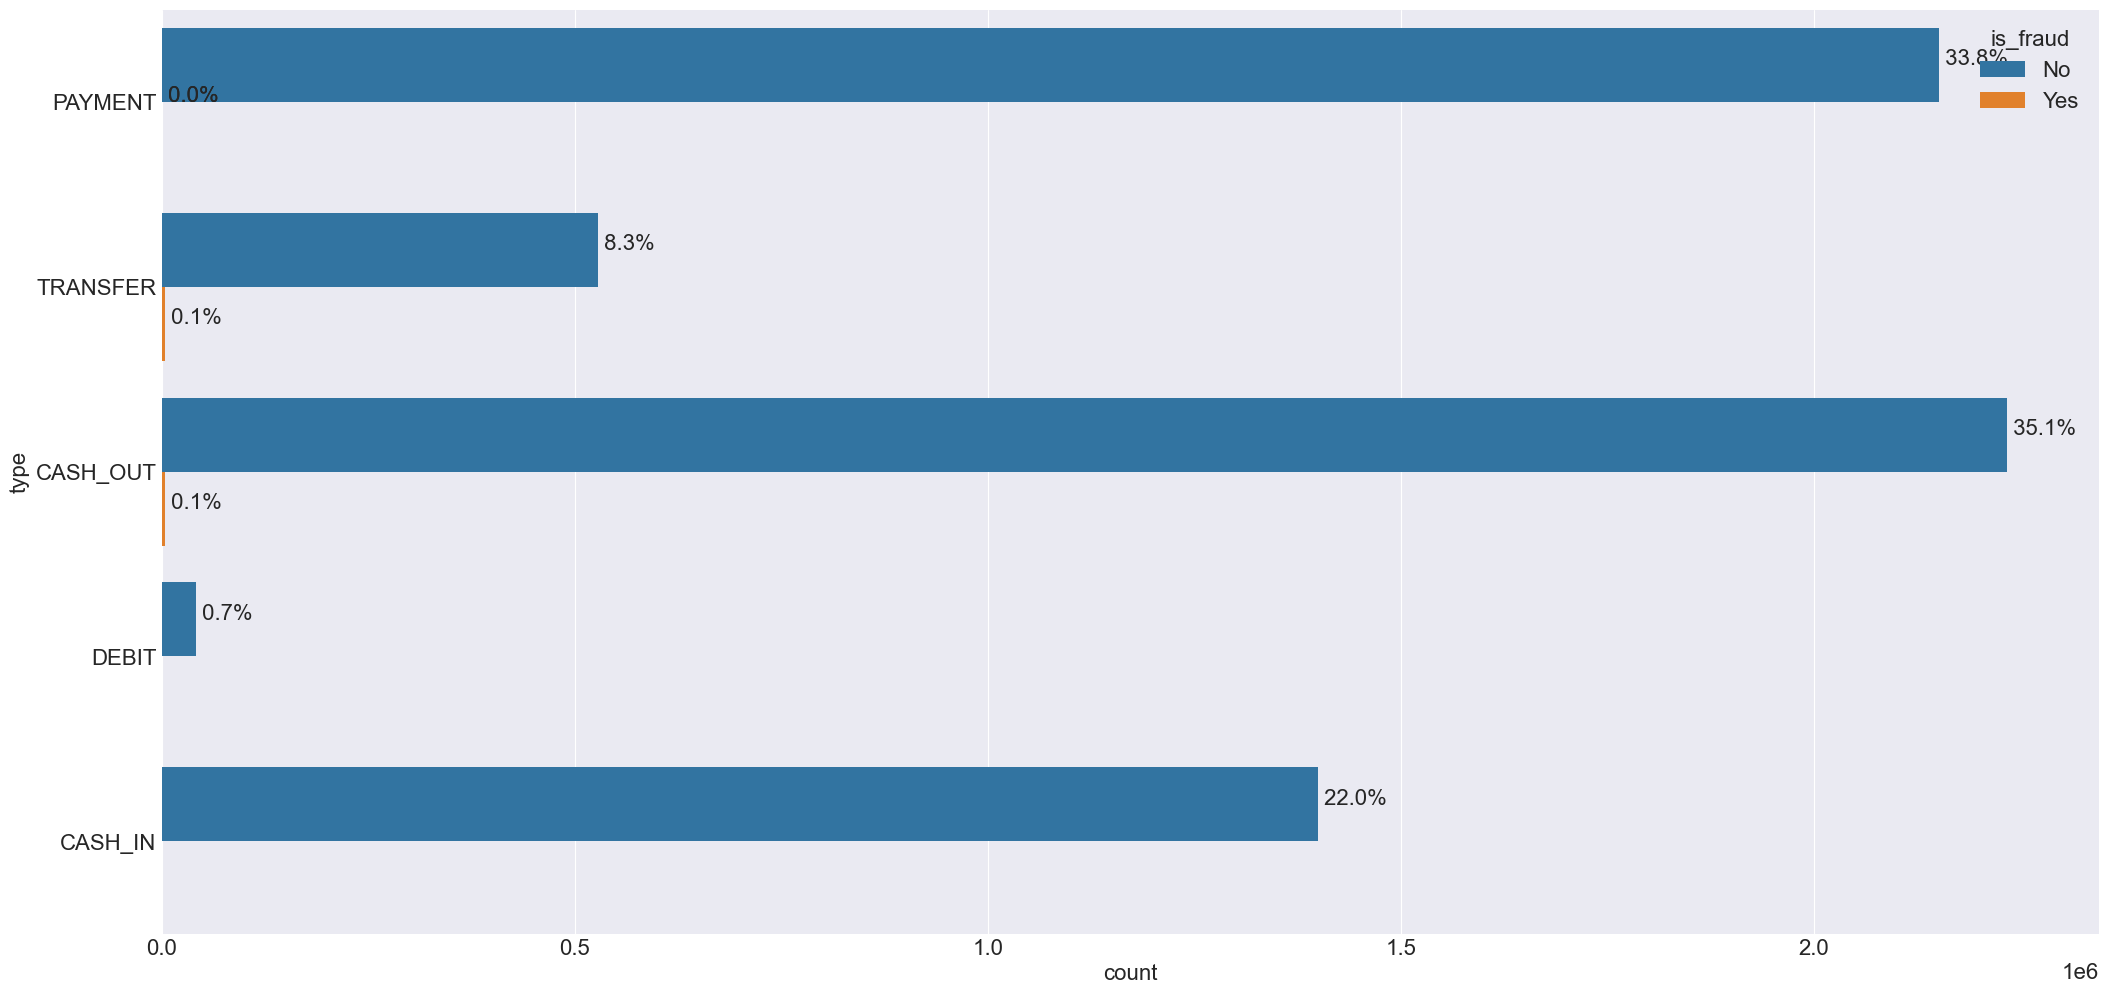

In [17]:
ax = sns.countplot(y='type', hue='is_fraud', data=df3)

total = df3['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

# Hypothesis

## The majority fraud transiction occours for the same user.

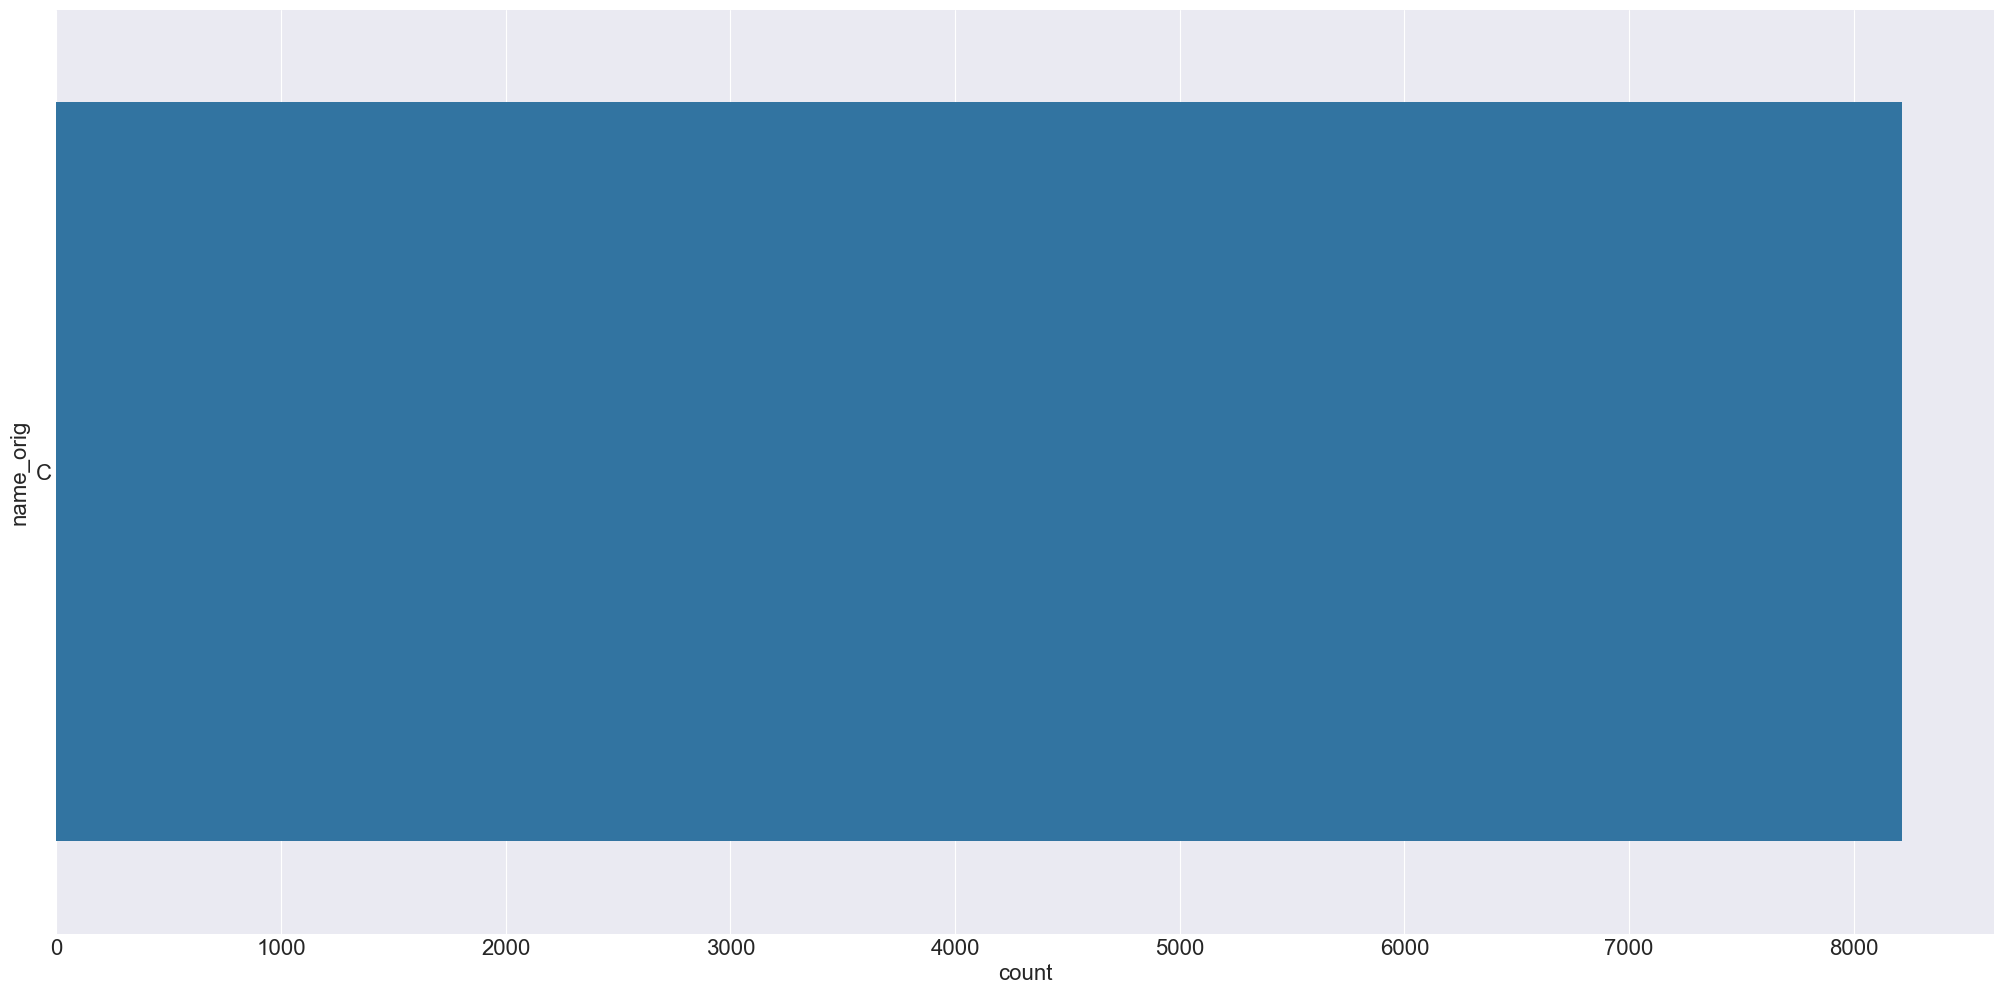

In [18]:
aux1 = df3[df3['is_fraud'] == 'Yes']
sns.countplot(y='name_orig', data=aux1);

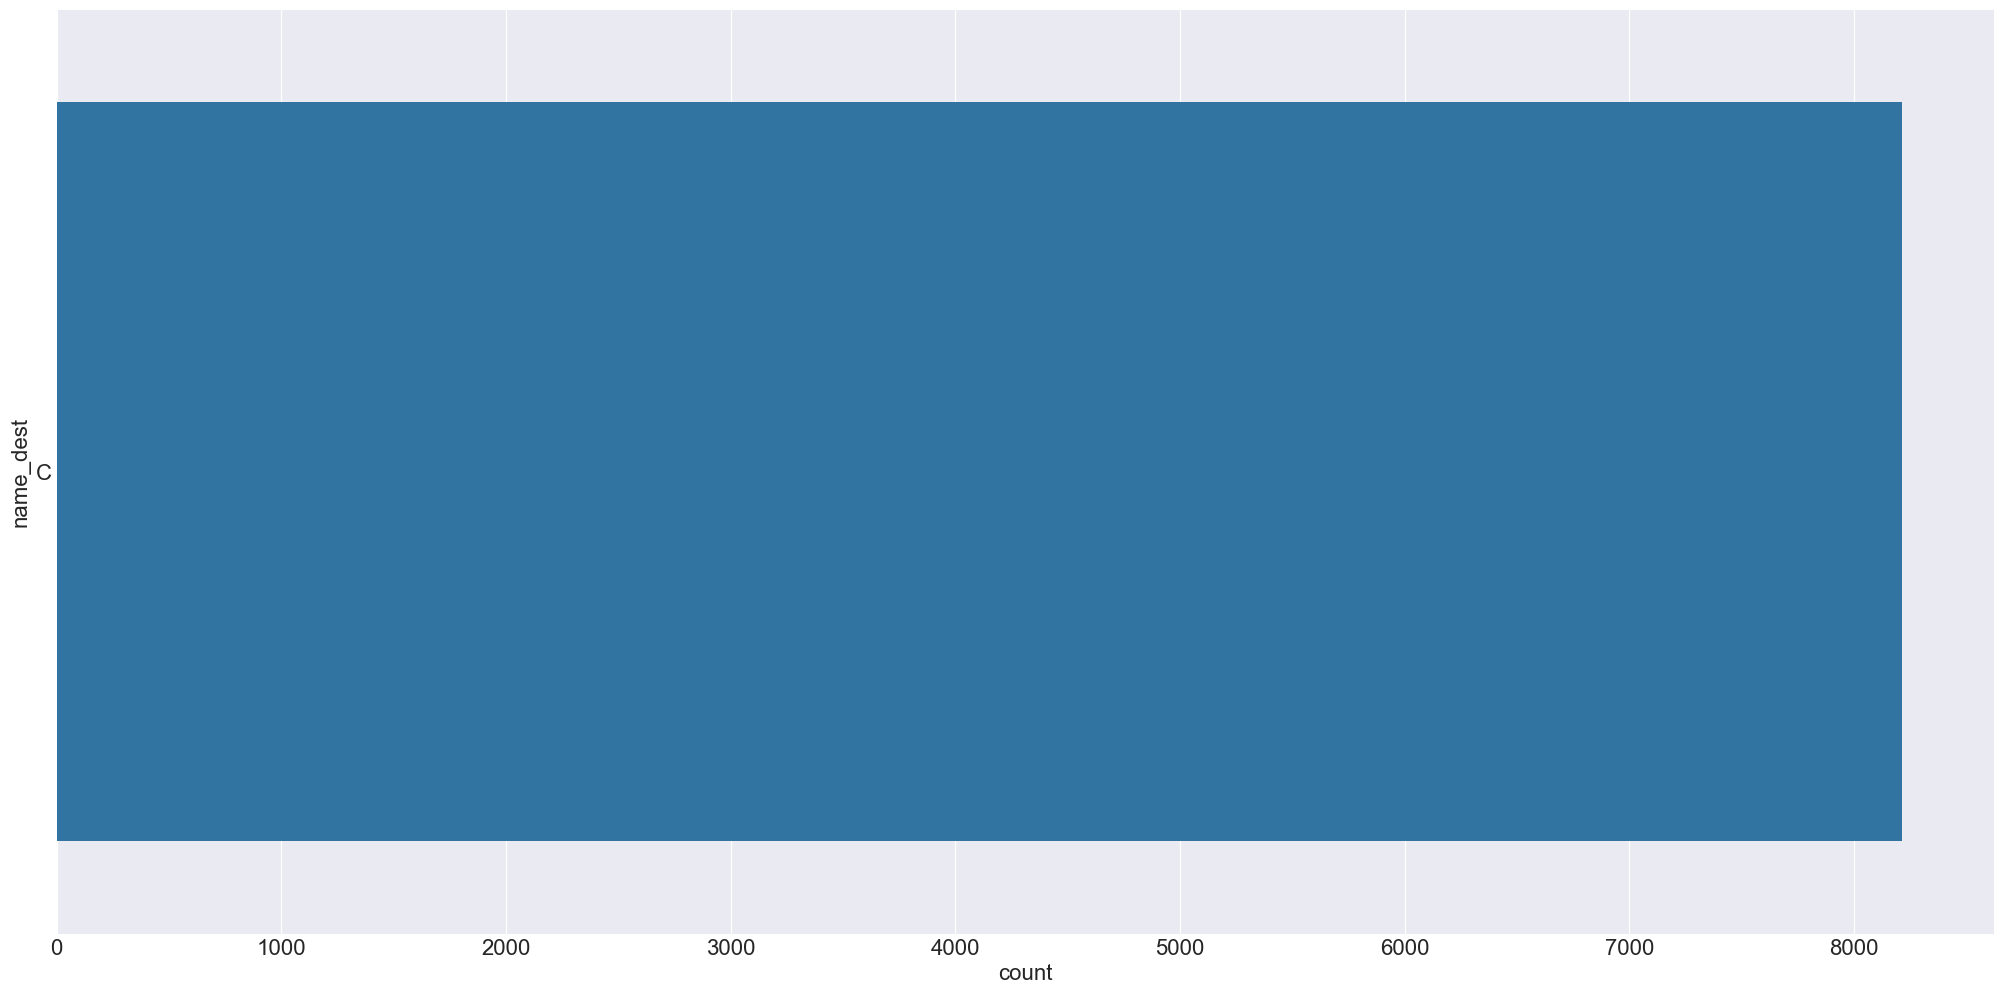

In [19]:
sns.countplot(y='name_dest', data=aux1);

## Fraud transactions occours at least in 3 days.

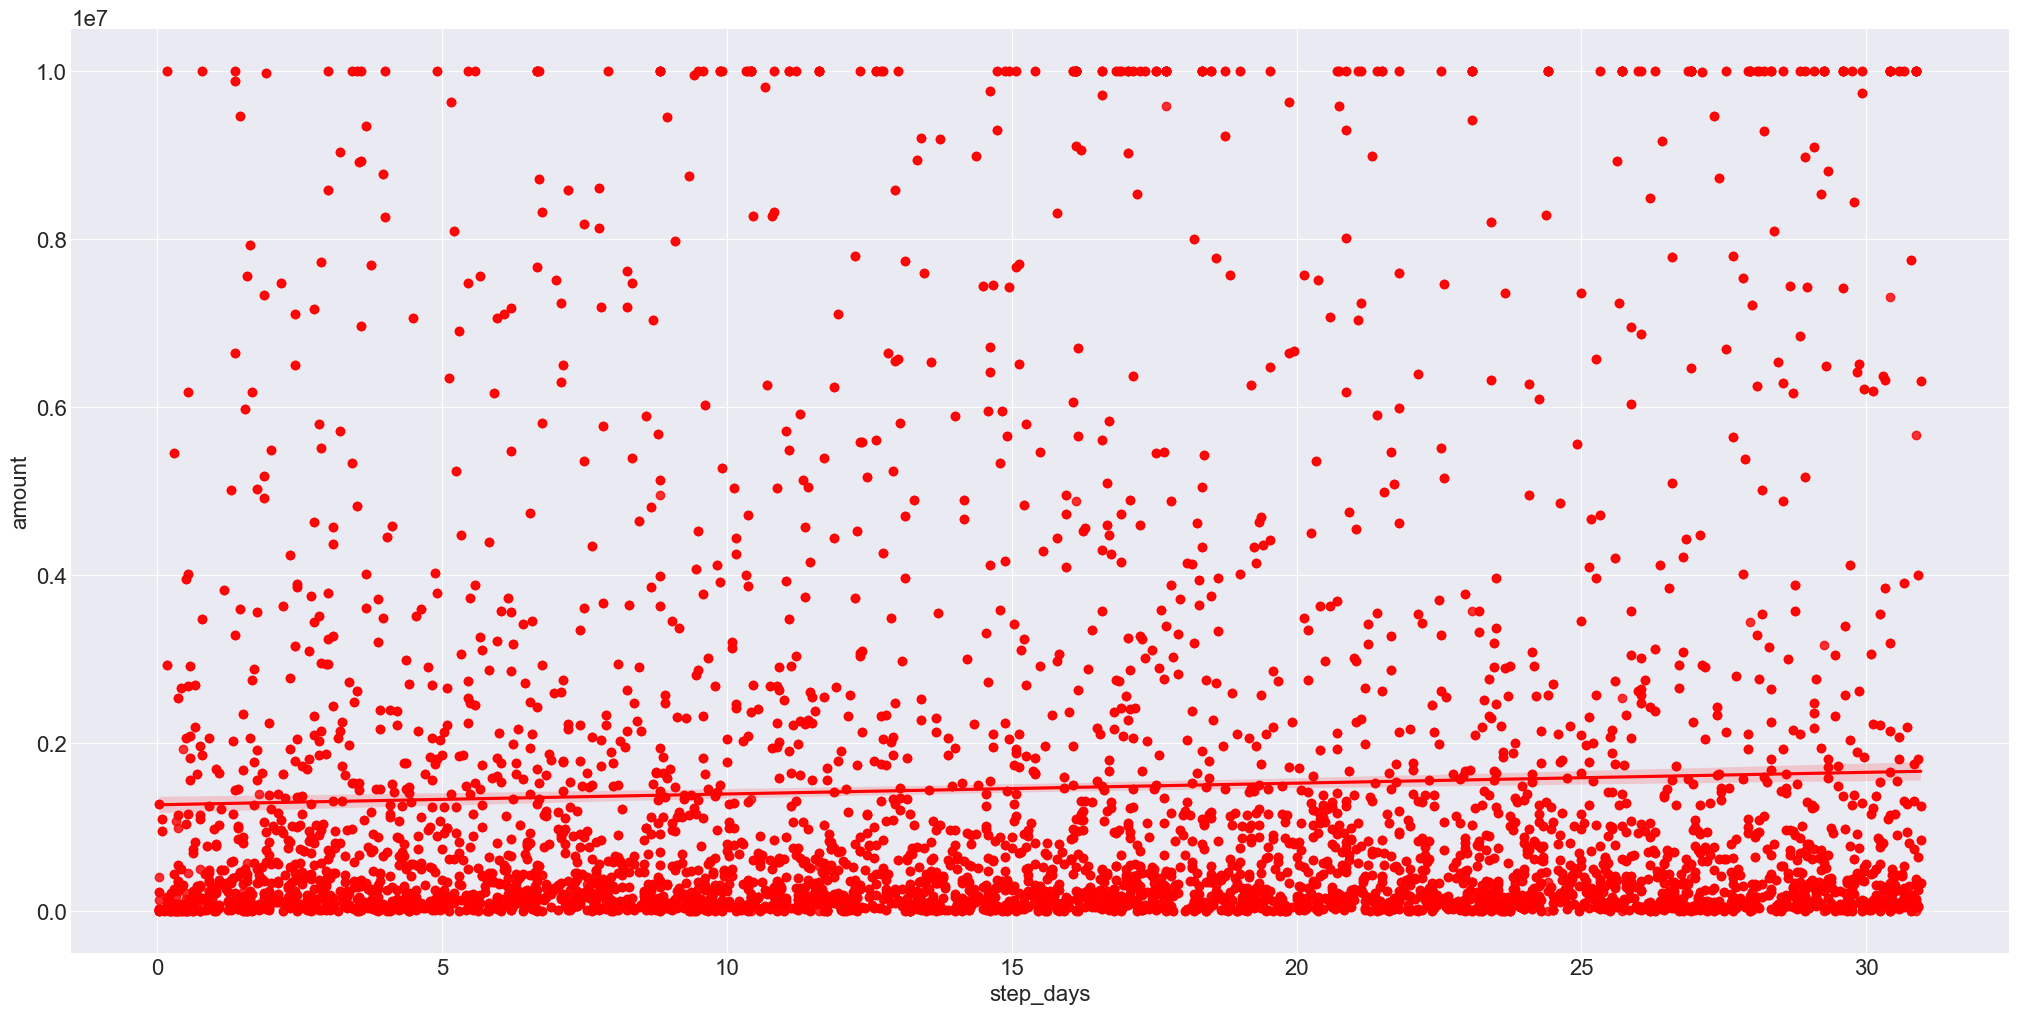

In [20]:
aux1 = df3[df3['is_fraud'] == 'Yes']
sns.regplot(x='step_days', y='amount', data=aux1,color='red');

# Numerical Analysis

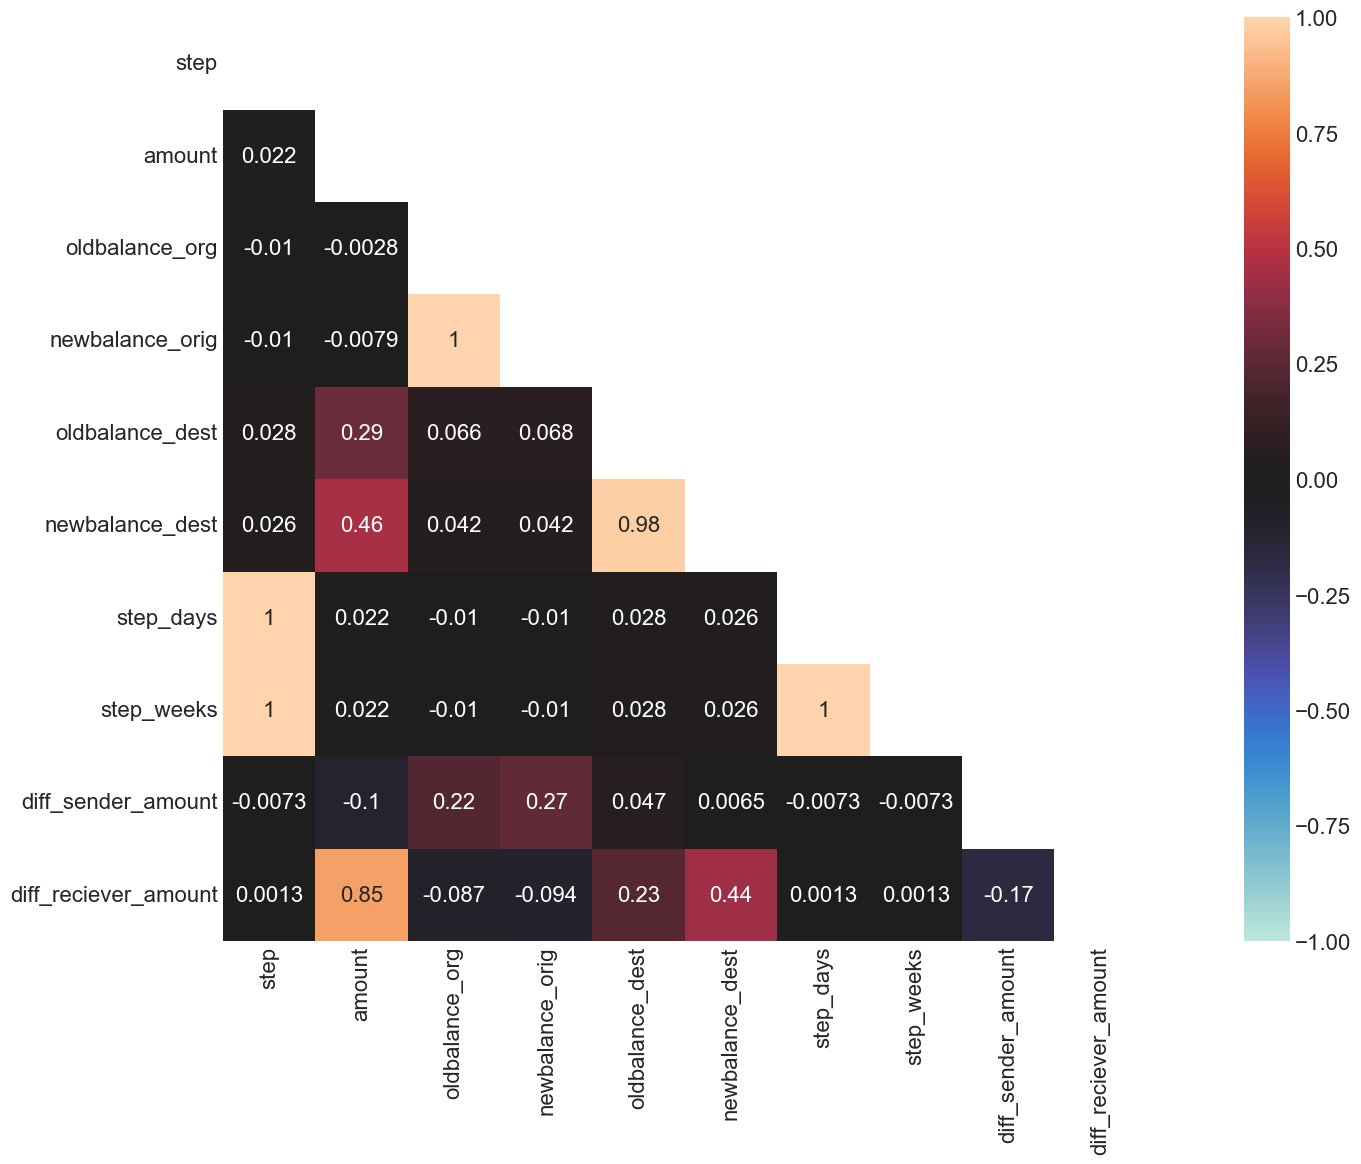

In [21]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

In [22]:
df4=df3.copy()

# Defining x and y

In [23]:
X = df4.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest', 
                      'step_weeks', 'step_days'], axis=1)
y = df4['is_fraud'].map({'Yes': 1, 'No': 0})
y.head(5)

0    0
1    0
2    1
3    1
4    0
Name: is_fraud, dtype: int64

# Split dataset into training and testing dataset

In [24]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

# OneHotEncoding
OneHotEncoder creates a binary vector representation of the categorical data, where each column represents a unique category.

In [25]:
from category_encoders import OneHotEncoder
ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

# Rescaling

## Why MinMaxScaler?
StandardScaler follows Standard Normal Distribution (SND). Therefore, it makes mean = 0 and scales the data to unit variance. MinMaxScaler scales all the data features in the range [0, 1] or else in the range [-1, 1] if there are negative values in the dataset.

In [26]:
from sklearn.preprocessing   import MinMaxScaler
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_sender_amount', 'diff_reciever_amount']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

In [27]:
final_columns_selected = ['step', 'oldbalance_org', 
                          'newbalance_orig', 'newbalance_dest', 
                          'diff_sender_amount', 'diff_reciever_amount', 
                          'type_TRANSFER']
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

XGBoost Classifier

In [29]:
from xgboost  import XGBClassifier

In [30]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [33]:
accuracy = balanced_accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
dataset=pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3)}, 
                        index=['XGBClassifier'])

In [34]:
dataset

,Balanced Accuracy,Precision,Recall,F1
XGBClassifier,0.919,0.954,0.839,0.893


In [36]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016706
           1       0.95      0.84      0.89      1314

    accuracy                           1.00   1018020
   macro avg       0.98      0.92      0.95   1018020
weighted avg       1.00      1.00      1.00   1018020

